In [1]:
from math import factorial
from predict_np import predict_from_np
from skfda.representation.grid import FDataGrid
from skfda.representation import FData
from skfda.representation.basis import FDataBasis, MonomialBasis
from skfda.ml.regression import LinearRegression
from skfda.misc import inner_product
import numpy as np

In [2]:
class ShapleyFda:
    def __init__(
            self,
            predict_fn,
            X,
            derivate_X,
            abscissa_points,
            target,
            domain_range,
            verbose,
            debug
        ):
        self.predict_fn = predict_fn
        self.X = X
        self.derivate_X = derivate_X
        self.abscissa_points = abscissa_points
        self.target = target
        self.domain_range = domain_range
        self.verbose = verbose
        self.debug = debug

    def validations(self, num_intervals, set_intervals):
        pass

    def to_numpy(self, obj):
        obj_np = obj
        if isinstance(obj, int) or isinstance(obj, float):
            obj_np = np.array([obj])
        return obj_np
        
    def create_set_intervals(self, num_intervals, intervals):
        if num_intervals is None and intervals is None:
            raise ValueError("Either num_intervals or intervals must not be None")
        elif num_intervals:
            ini_domain_range = self.domain_range[0]
            end_domain_range = self.domain_range[1]
            long_domain_range = end_domain_range - ini_domain_range
            h = (long_domain_range)/num_intervals
            intervals_lower_bound = np.arange(ini_domain_range, end_domain_range, h)
            intervals_upper_bound = np.arange(ini_domain_range + h, end_domain_range + h, h)
            intervals = np.stack((intervals_lower_bound, intervals_upper_bound), axis=1)
        elif intervals:
            # TODO: if the user provides intervals, standardise it so that
            # it has the same shape as if it were created by the previous statement
            pass
        return intervals

    def create_permutations(self, num_intervals, num_permutations):
        set_permutations = set()
        total_set_permutations = len(set_permutations)
        # Error when impossible number of permutations is desired
        if num_permutations > factorial(num_intervals):
            raise ValueError("num_permutations can no be greater than the factorial of number of intervals")
        # Iterate until the desired number of permutations is obtained
        while total_set_permutations < num_permutations:
            new_permutation = np.random.choice(a=num_intervals, size=num_intervals, replace=False)
            new_permutation = tuple(new_permutation)
            set_permutations.add(new_permutation)
            total_set_permutations = len(set_permutations)
        return set_permutations

    def fn_real(self):
        def inner_debug_fn_real(set_abscissa_points):
            set_abscissa_points = self.to_numpy(set_abscissa_points)
            f_points = np.full(shape=(self.X.shape[0], set_abscissa_points.shape[0]), fill_value=-1)
            return f_points
        fn_to_return = self.compute_f
        if self.debug:
            fn_to_return = inner_debug_fn_real
        return fn_to_return

    def fn_constant(self):
        def inner_fn_constant(set_abscissa_points):
            set_abscissa_points = self.to_numpy(set_abscissa_points)
            mean_val = np.mean(self.X, axis=1, keepdims=True)
            vector_ones = np.ones(shape=(1, set_abscissa_points.shape[0]))
            f_points = np.dot(mean_val, vector_ones)
            return f_points
        def inner_debug_fn_constant(set_abscissa_points):
            set_abscissa_points = self.to_numpy(set_abscissa_points)
            values = np.full(shape=(self.X.shape[0], set_abscissa_points.shape[0]), fill_value=0)
            return values
        fn_to_return = inner_fn_constant
        if self.debug:
            fn_to_return = inner_debug_fn_constant
        return fn_to_return

    def fn_linear(self, abscissa):
        f_abscissa = self.compute_f(abscissa)
        derivative_f_abscissa = self.compute_derivative_f(abscissa)
        beta_0 = np.subtract(f_abscissa, np.multiply(abscissa, derivative_f_abscissa))
        beta_1 = derivative_f_abscissa.copy()
        def inner_fn_linear(set_abscissa_points):
            set_abscissa_points = self.to_numpy(set_abscissa_points)
            values = np.add(beta_0, np.multiply(beta_1, set_abscissa_points))
            return values
        def inner_debug_fn_linear(set_abscissa_points):
            set_abscissa_points = self.to_numpy(set_abscissa_points)
            values = np.full(shape=(self.X.shape[0], set_abscissa_points.shape[0]), fill_value=1)
            return values
        fn_to_return = inner_fn_linear
        if self.debug:
            fn_to_return = inner_debug_fn_linear
        return fn_to_return

    def fn_cubic(self, abscissa_ini, abscissa_end):
        f_abscissa_ini = self.compute_f(abscissa_ini)
        f_abscissa_end = self.compute_f(abscissa_end)
        derivative_f_ini = self.compute_derivative_f(abscissa_ini)
        derivative_f_end = self.compute_derivative_f(abscissa_end)
        dif_abscissa = abscissa_end - abscissa_ini
        beta_0 = np.divide(f_abscissa_end, dif_abscissa)
        beta_1 = np.divide(-f_abscissa_ini, dif_abscissa)
        beta_2 = np.divide(np.subtract(np.add(np.multiply(derivative_f_end, dif_abscissa), f_abscissa_ini), f_abscissa_end), dif_abscissa ** 3)
        beta_3 = np.divide(np.subtract(np.add(np.multiply(derivative_f_ini, dif_abscissa), f_abscissa_ini), f_abscissa_end), dif_abscissa ** 3)
        beta_values = np.column_stack((beta_0, beta_1, beta_2, beta_3))
        def inner_fn_cubic(set_abscissa_points):
            set_abscissa_points = self.to_numpy(set_abscissa_points)
            polynomials = np.row_stack((
                np.subtract(set_abscissa_points, abscissa_ini),
                np.subtract(set_abscissa_points, abscissa_end),
                np.multiply(np.power(np.subtract(set_abscissa_points, abscissa_ini), 2), np.subtract(set_abscissa_points, abscissa_end)),
                np.multiply(np.subtract(set_abscissa_points, abscissa_ini),np.power(np.subtract(set_abscissa_points, abscissa_end), 2))
            ))
            values = np.matmul(beta_values, polynomials)
            return values
        def inner_debug_fn_cubic(set_abscissa_points):
            set_abscissa_points = self.to_numpy(set_abscissa_points)
            values = np.full(shape=(self.X.shape[0], set_abscissa_points.shape[0]), fill_value=3)
            return values
        fn_to_return = inner_fn_cubic
        if self.debug:
            fn_to_return = inner_debug_fn_cubic
        return fn_to_return

    def break_permutation(self, permutation, global_interval_position, use_interval):
        interval_position_inside_permutation = np.argwhere(global_interval_position == permutation).squeeze()
        # Given the permutation, some we will have to interpolate the information for some of the intervals.
        # Depending if the current interval is used or not.
        if use_interval:
            available_intervals = permutation[:(interval_position_inside_permutation + 1)]
            non_available_intervals = permutation[(interval_position_inside_permutation + 1):]
        else:
            available_intervals = permutation[:interval_position_inside_permutation]
            non_available_intervals = permutation[interval_position_inside_permutation:]
        return available_intervals, non_available_intervals

    def build_interpolation_fn(self, set_intervals, intervals_to_interpolate, labels):
        intervals_to_interpolate_shape = intervals_to_interpolate.shape
        list_to_return = np.empty(shape=intervals_to_interpolate_shape, dtype=type(self.compute_f))
        unique_labels = np.unique(labels)

        # For each label, decide what function to use.
        for label in unique_labels:
            label_position = np.ravel(np.argwhere(labels == label))                     
            intervals_labels = intervals_to_interpolate[label_position]
            domain_interval = set_intervals[intervals_labels]
            ini = np.min(domain_interval)
            end = np.max(domain_interval)
            is_first_interval_included = np.abs(ini - self.domain_range[0]) < 1e-7
            is_last_interval_included = np.abs(end - self.domain_range[1]) < 1e-7
            self.print("\t\t\tlabel:", label)
            self.print("\t\t\t\tintervals:", intervals_labels)
            self.print("\t\t\t\trange ini:", ini)
            self.print("\t\t\t\trange end:", end)
            # If the whole domain range is included, build a constant interpolation function
            if is_first_interval_included and is_last_interval_included:
                self.print("\t\t\t\tfunction: constant")
                list_to_return[label_position] = self.fn_constant()
            # else the first interval is included but the last one is not included, buil a linear interpolation
            elif is_first_interval_included and not is_last_interval_included:
                self.print("\t\t\t\tfunction: linear with abcissa:", end)
                list_to_return[label_position] = self.fn_linear(end)
            # else the first interval is not included but the last one is included, buil a linear interpolation
            elif not is_first_interval_included and is_last_interval_included:
                self.print("\t\t\t\tfunction: linear with abcissa:", ini)
                list_to_return[label_position] = self.fn_linear(ini)
            # In any other case, build a cubic interpolation function
            else:
                list_to_return[label_position] = self.fn_cubic(ini, end)
                self.print("\t\t\t\tfunction: cubic")
        list_to_return = list_to_return.tolist()
        return list_to_return
    
    def map_function_interval(self, set_intervals, non_available_intervals):
        # Check if there are consecutive intervals
        sorted_labels_intervals = np.empty(shape=non_available_intervals.shape, dtype=non_available_intervals.dtype)
        sorting_positions = np.argsort(non_available_intervals)
        sorted_intervals = non_available_intervals[sorting_positions]
        i_interval = 0
        label_interval = 0
        previous_interval = None
        for interval in sorted_intervals:
            # Two intervals are not consecutive if the difference between their indexes
            # is greater than 1. We consider that the previous interval to the first one is
            # the void set. Therefore, the first set will always be different from the
            # previous one.
            if ((previous_interval is None) or ((interval - previous_interval) > 1)):
                label_interval += 1
            sorted_labels_intervals[i_interval] = label_interval
            previous_interval = interval
            i_interval += 1
        labels_intervals = sorted_labels_intervals[np.argsort(sorting_positions)]
        self.print("\t\t\tunique_intervals:", labels_intervals)
        # Build the function for each of the (sorted) interval
        sorted_set_fns = self.build_interpolation_fn(set_intervals, sorted_intervals, sorted_labels_intervals)
        set_fns = [sorted_set_fns[i] for i in sorting_positions]
        return [(interval, fn) for (interval, fn) in zip(non_available_intervals, set_fns)]

    def map_abcissa_interval(self, set_intervals):
        set_intervals_shape = set_intervals.shape
        map_object = np.full(shape=self.abscissa_points.shape, fill_value=1, dtype=int)
        num_intervals = set_intervals_shape[0]
        last_end_interval = set_intervals[num_intervals-1, 1]
        i_abcissa = 0
        for abscissa in self.abscissa_points:
            if(np.abs(abscissa - last_end_interval) < 1e-7):
                interval_position = num_intervals - 1
            else:
                interval_position = np.ravel(np.argwhere((abscissa >= set_intervals[:, 0]) & (abscissa < set_intervals[:, 1])))
                interval_position = interval_position[0]
            map_object[i_abcissa] = interval_position
            i_abcissa += 1
        return map_object
    
    def recompute_covariate(
            self,
            set_intervals,
            mapping_abcissa_interval,
            global_interval_position,
            permutation,
            use_interval
        ):
        recomputed_covariate = np.empty(shape=self.X.shape)
        permutation_array = np.array(permutation)
        # Break the permutation into two parts:
            # first part is the one we are allowed to use
            # second part is the one to be interpolated, i.e, non-available information
        available_intervals, non_available_intervals = self.break_permutation(permutation_array, global_interval_position, use_interval)
        self.print(
            "\t\tuse_interval:", use_interval,
            "\tavailable_intervals:", available_intervals, 
            "\tnon_available_intervals:", non_available_intervals
        )
        # For the available_intervals we will use real values.
        # This must be a list of tuples.
        fun_available_intervals = [(x, self.fn_real()) for x in available_intervals]
        # This must be a list of tuples.
        fun_non_available_intervals = self.map_function_interval(set_intervals, non_available_intervals)
        fun_intervals = [*fun_available_intervals, *fun_non_available_intervals]
        dic_fun_intervals = {interval: funct for (interval, funct) in fun_intervals}
        self.print("\t\t\tall_fun", fun_intervals)
        # For each abcissa_interval, recompute the covariate
        for interval_permutation in permutation_array:
            interval_position = np.ravel(np.argwhere(mapping_abcissa_interval == interval_permutation))
            interval_abcissa = self.abscissa_points[interval_position]
            function_to_apply = dic_fun_intervals[interval_permutation]
            recomputed_values = function_to_apply(interval_abcissa)
            recomputed_covariate[:, interval_position] = recomputed_values
        self.print("\t\t\trecomputed_covariate:", recomputed_covariate.tolist())
        return recomputed_covariate

    def obtain_r2(self, covariate, target):
        prediction = self.predict_fn(covariate)
        self.print("\t\t\tprediction:", prediction)
        self.print("\t\t\ttarget:", target)
        diff_target_pred = np.subtract(target, prediction)
        diff_target_pred_sq = np.power(diff_target_pred, 2)
        rss = np.sum(diff_target_pred_sq)
        target_mean = np.mean(target)
        diff_target_target_mean = np.subtract(target, target_mean)
        diff_target_target_mean_sq = np.power(diff_target_target_mean, 2)
        tss = np.sum(diff_target_target_mean_sq)
        self.print("\t\t\trss:", rss)
        self.print("\t\t\ttss:", tss)
        r2 = 1 - rss/tss
        return r2

    def compute_interval_relevance(self, set_intervals, set_permutations, mapping_abcissa_interval, interval_position):
        set_differences = []
        # For each permutation
        for i_permutation in set_permutations:
            self.print("\tPermutation:", i_permutation)
            # Recreate the set of functions without considering the interval
            covariate_no_interval = self.recompute_covariate(
                set_intervals,
                mapping_abcissa_interval,
                interval_position,
                i_permutation,
                use_interval = False
            )
             # Recreate the set of functions considering the interval
            covariate_interval = self.recompute_covariate(
                set_intervals,
                mapping_abcissa_interval,
                interval_position,
                i_permutation,
                use_interval = True
            )
            # Retrain the model without considering the interval and obtain the R^2
            self.print("\t\tdebug for no interval")
            r2_no_interval = self.obtain_r2(covariate_no_interval, self.target)
            self.print("\t\t\tr2_no_interval:", r2_no_interval)
            # Retrain the model considering the interval and obtain the R^2
            self.print("\t\tdebug for interval")
            r2_interval = self.obtain_r2(covariate_interval, self.target)
            self.print("\t\t\tr2_interval:", r2_interval)
            # Compute the differnece of R^2
            diff_r2 = r2_interval- r2_no_interval
            # Stack the difference
            set_differences.append(diff_r2)
        # Compute the mean value
        mean_val = np.mean(set_differences)
        return mean_val

    def compute_function_from_matrix(self, set_abscissa_points, matrix):
        set_abscissa_points = self.to_numpy(set_abscissa_points)
        i_point = 0
        f_points = np.empty(shape=(matrix.shape[0], set_abscissa_points.shape[0]))
        for point in set_abscissa_points:
            if (point < self.domain_range[0] or point > self.domain_range[1]):
                raise ValueError("points contains a point outside the domain range (domain_range)")
            min_position = np.max(np.argwhere(point >= self.abscissa_points))
            num_min = self.abscissa_points[min_position]
            if (np.abs(num_min - point) < 1e-7):
                f_points[:, i_point] = matrix[:, min_position]
            else:
                max_position = np.min(np.argwhere(point < self.abscissa_points))
                num_max = self.abscissa_points[max_position]
                w_min = 1 - (point - num_min)/(num_max - num_min)
                w_max = 1 - (num_max - point)/(num_max - num_min)
                f_min = matrix[:, min_position]
                f_max = matrix[:, max_position]
                f_eval_point = w_min * f_min + w_max * f_max
                f_points[:, i_point] = f_eval_point
            i_point += 1
        return f_points

    def compute_f(self, set_abscissa_points):
        return self.compute_function_from_matrix(set_abscissa_points, self.X)
    
    def compute_derivative_f(self, set_abscissa_points):
        return self.compute_function_from_matrix(set_abscissa_points, self.derivate_X)

    def compute_f_set_intervals(self, set_intervals):
        set_intervals_shape = set_intervals.shape
        new_shape = [x for x in set_intervals_shape]
        new_shape.insert(0, self.X.shape[0])
        f_set_intervals = np.empty(shape=new_shape)
        ini = set_intervals[:, 0]
        end = set_intervals[:, 1]
        f_ini = self.compute_f(ini)
        f_end = self.compute_f(end)
        n_intervals = set_intervals_shape[0]
        for i_interval in range(n_intervals):
            f_set_intervals[:, i_interval, 0] = f_ini[:, i_interval]
            f_set_intervals[:, i_interval, 1] = f_end[:, i_interval]
        return f_set_intervals

    def print(self, *args):
        if self.verbose:
            str_print = ""
            for arg in args:
                str_print = str_print + " " + str(arg)
            print(str_print)

    def compute_shapley_value(self, num_permutations, num_intervals=None, intervals=None):
        # Create a set of intervals: 
        #       we will treat all the intervals as [a, b), 
        #       except for the las one, which will be [a, b]
        set_intervals = self.create_set_intervals(num_intervals, intervals)
        self.print("set_intervals:\n", set_intervals)
        # Perform validations
        self.validations(num_intervals, set_intervals)
        num_intervals = set_intervals.shape[0] if num_intervals is None else num_intervals
        # Get the set of permutations
        set_permutations = self.create_permutations(num_intervals=num_intervals, num_permutations=num_permutations)
        self.print("set_permutations:", set_permutations)
        # Map each abcissa point with its interval
        mapping_abcissa_interval = self.map_abcissa_interval(set_intervals)
        self.print("abcissa:", self.abscissa_points, " ", "abcissa_interval:", mapping_abcissa_interval)
        # For each interval, compute the relevance
        intervals_relevance = []
        if self.debug:
            num_intervals = 1
        for i_interval in range(num_intervals):
            interval = set_intervals[i_interval]
            self.print("Computing relevance for interval:", interval, "whose index is", i_interval)
            relevance = self.compute_interval_relevance(set_intervals, set_permutations, mapping_abcissa_interval, i_interval)
            result = [interval, relevance]
            intervals_relevance.append(result)
        return intervals_relevance

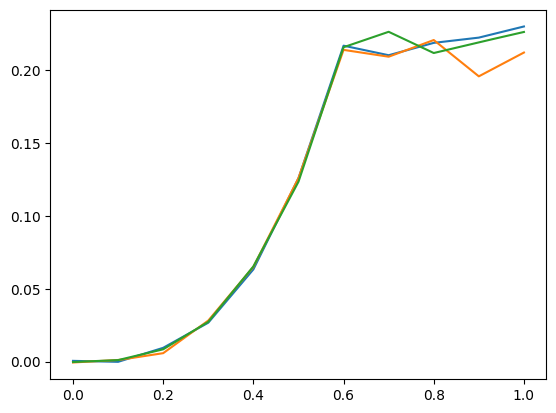

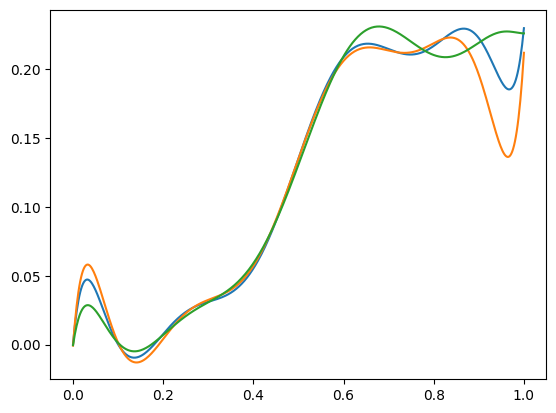

In [3]:
# Prepare the data
np.random.seed(1234)
num_functions = 3
rate_important_intervals = 0.7
basis = MonomialBasis(n_basis=10)
ini = 0
end = 1
domain_range = (ini, end)
step = 0.1
abscissa_points = np.arange(ini, end + step, step)
total_abscissa_points = abscissa_points.shape[0]
total_important_abcissa = int(np.floor(rate_important_intervals * abscissa_points.shape[0]))
vector_ones = np.full(shape=(num_functions, 1), fill_value=1)
vector_fun = np.array([x ** 3 for x in abscissa_points[:total_important_abcissa]], ndmin=2)
X_no_noise = np.dot(vector_ones, vector_fun) + np.random.normal(loc=0, scale=0.001, size=(num_functions, total_important_abcissa))
X_last_abcissa = np.reshape(X_no_noise[:, -1], newshape=(-1, 1))
X_noise = np.random.normal(loc=X_last_abcissa, scale= 0.01, size=(num_functions, total_abscissa_points - total_important_abcissa))
y = np.empty(shape=num_functions)
for i in range(num_functions):
    y[i] = np.dot(X_no_noise[i, :], X_no_noise[i, :])
X = np.column_stack((X_no_noise, X_noise))
X_grid = FDataGrid(data_matrix=X, grid_points=abscissa_points, domain_range=domain_range)
X_basis = X_grid.to_basis(basis)
# Derivative
vector_derivative = np.array([3 * (x ** 2) for x in abscissa_points[:total_important_abcissa]], ndmin=2)
derivative_X_no_noise = np.dot(vector_ones, vector_derivative) + np.random.normal(loc=0, scale=0.001, size=(num_functions, total_important_abcissa))
derivative_X_noise = np.random.normal(loc=0, scale=0.001, size=(num_functions, total_abscissa_points - total_important_abcissa))
derivative_X = np.column_stack((derivative_X_no_noise, derivative_X_noise))
# Plot
zzz = X_grid.plot()
yyy = X_basis.plot()

In [4]:
# Fit the model
linear_reg = LinearRegression()
_ = linear_reg.fit(X_basis, y)

In [5]:
predict_function = predict_from_np(
    grid_points=abscissa_points,
    domain_range=domain_range,
    basis=basis,
    predict_fn = linear_reg.predict
)

In [6]:
shapley_fda = ShapleyFda(
    predict_fn=predict_function,
    X=X,
    derivate_X=derivative_X,
    abscissa_points=abscissa_points,
    target=y,
    domain_range=domain_range,
    verbose=True,
    debug=False,
)
values_shap = shapley_fda.compute_shapley_value(num_intervals=5, num_permutations=1)
#print("relevance:\n", values_shap, "\n")

 set_intervals:
 [[0.  0.2]
 [0.2 0.4]
 [0.4 0.6]
 [0.6 0.8]
 [0.8 1. ]]
 set_permutations: {(0, 2, 3, 1, 4)}
 abcissa: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]   abcissa_interval: [0 0 1 1 2 2 3 3 4 4 4]
 Computing relevance for interval: [0.  0.2] whose index is 0
 	Permutation: (0, 2, 3, 1, 4)
 		use_interval: False 	available_intervals: [] 	non_available_intervals: [0 2 3 1 4]
 			unique_intervals: [1 1 1 1 1]
 			label: 1
 				intervals: [0 1 2 3 4]
 				range ini: 0.0
 				range end: 1.0
 				function: constant
 			all_fun [(0, <function ShapleyFda.fn_constant.<locals>.inner_fn_constant at 0x127a43790>), (2, <function ShapleyFda.fn_constant.<locals>.inner_fn_constant at 0x127a43790>), (3, <function ShapleyFda.fn_constant.<locals>.inner_fn_constant at 0x127a43790>), (1, <function ShapleyFda.fn_constant.<locals>.inner_fn_constant at 0x127a43790>), (4, <function ShapleyFda.fn_constant.<locals>.inner_fn_constant at 0x127a43790>)]
 			recomputed_covariate: [[0.12035958689014305, 

In [7]:
X

array([[ 4.71435164e-04, -1.90975695e-04,  9.43270697e-03,
         2.66873481e-02,  6.32794113e-02,  1.25887163e-01,
         2.16859588e-01,  2.10299895e-01,  2.18793802e-01,
         2.22393978e-01,  2.30041104e-01],
       [-6.36523504e-04,  1.01569637e-03,  5.75731505e-03,
         2.81500357e-02,  6.49919460e-02,  1.25953324e-01,
         2.13978745e-01,  2.09285692e-01,  2.20734286e-01,
         1.95808473e-01,  2.12147660e-01],
       [-3.34077366e-04,  1.00211836e-03,  8.40545341e-03,
         2.72890919e-02,  6.53211582e-02,  1.23453094e-01,
         2.15797354e-01,  2.26387046e-01,  2.11818951e-01,
         2.19171730e-01,  2.26273139e-01]])

In [8]:
print("relevance:\n", values_shap, "\n")

relevance:
 [[array([0. , 0.2]), -69012.9952918892], [array([0.2, 0.4]), -3.2145815502564763], [array([0.4, 0.6]), 49187.49992318504], [array([0.6, 0.8]), 25884.89633091097], [array([0.8, 1. ]), 3.9930146887317526]] 



In [12]:
# Linear
point = 0.2
f_point = shapley_fda.compute_f(point)
fn_lin = shapley_fda.fn_linear(point)
fn_lin(1)

array([[0.10533503],
       [0.10178623],
       [0.10457767]])

In [15]:
# Cubic
ini = 0.2
end = 0.4
f_ini = shapley_fda.compute_f(ini)
f_end = shapley_fda.compute_f(end)
fn_cubic = shapley_fda.fn_cubic(ini, end)
fn_cubic(0.3)

array([[0.02736108],
       [0.02636934],
       [0.02790483]])

In [11]:
X

array([[ 4.71435164e-04, -1.90975695e-04,  9.43270697e-03,
         2.66873481e-02,  6.32794113e-02,  1.25887163e-01,
         2.16859588e-01,  2.10299895e-01,  2.18793802e-01,
         2.22393978e-01,  2.30041104e-01],
       [-6.36523504e-04,  1.01569637e-03,  5.75731505e-03,
         2.81500357e-02,  6.49919460e-02,  1.25953324e-01,
         2.13978745e-01,  2.09285692e-01,  2.20734286e-01,
         1.95808473e-01,  2.12147660e-01],
       [-3.34077366e-04,  1.00211836e-03,  8.40545341e-03,
         2.72890919e-02,  6.53211582e-02,  1.23453094e-01,
         2.15797354e-01,  2.26387046e-01,  2.11818951e-01,
         2.19171730e-01,  2.26273139e-01]])